# Sector ETFs Recommender System
###Objective: To train a stacking machine learning model that can recommend Sector ETFs that have the best 1-day return. 
### Members: Johann, Jing Wen, Zi Jun

In [0]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
import datetime
import cvxpy as cp

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Inputs

### We select the oldest set of Sector ETFs:
* SPDR Consumer Staples ETF (XLP) 1998-12-16
* SPDR Consumer Discretionary ETF (XLY) 1998-12-16
* SPDR Energy ETF (XLE) 1998-12-16
* SPDR Financials ETF (XLF) 1998-12-16
* SPDR Health Care ETF (XLV) 1998-12-16
* SPDR Industrial ETF (XLI) 1998-12-16
* SPDR Materials ETF (XLB) 1998-12-16
* SPDR Technology ETF (XLK) 1998-12-16
* SPDR Utilities ETF (XLU) 1998-12-16


---


### Excluded:
* SPDR Telecommunication Services ETF (XLC) 2018-06-18
* SPDR Real Estate ETF (XLRE) 2015-10-07

Note: Due to the relative infancy of Sector ETF concept, our dataset is limited and recent.

In [0]:
#Input Sector ETF Tickers
tickers = ['XLP', 'XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

In [0]:
#Input dates
startdate = datetime.datetime(1999, 3, 31)
enddate =  datetime.datetime(2019, 4, 1)

#Extra data for Arima model
arima_startdate = datetime.datetime(1998, 12, 17)
arima_enddate = datetime.datetime(1999, 3, 30)

#Extra data for SMA 
SMA_startdate = datetime.datetime(1999, 2, 18)
SMA_enddate =  datetime.datetime(1999, 3, 30)

# Data Retrieval

In [0]:
#Retrieve prices
prices_dict = {}
for ticker in tickers:
    ticker_prices = pdr.get_data_yahoo(ticker, startdate, enddate)
    prices_dict[ticker] = ticker_prices['Adj Close']

#Returns
prices = pd.DataFrame(prices_dict)
returns = prices.pct_change().dropna()



In [203]:
print(returns.head(10))

                 XLP       XLY       XLE       XLF       XLV       XLI  \
Date                                                                     
1999-04-01  0.001773 -0.001093 -0.001271  0.002506  0.000000  0.010650   
1999-04-05  0.005310  0.013129  0.024173  0.020001  0.022321  0.021700   
1999-04-06 -0.011151  0.005400 -0.009938 -0.007353  0.001090 -0.005464   
1999-04-07 -0.001186  0.008593 -0.010037  0.027161  0.019085  0.001832   
1999-04-08  0.023173  0.022364  0.010139  0.018027  0.010167  0.005480   
1999-04-09  0.002323  0.009375  0.018820 -0.002361  0.003176  0.000608   
1999-04-12  0.016802  0.008256  0.007390  0.017754  0.025344  0.024213   
1999-04-13  0.003419 -0.005117 -0.001223 -0.001165 -0.010299  0.007682   
1999-04-14 -0.030097 -0.022633 -0.012240 -0.012803 -0.009363  0.021700   
1999-04-15 -0.024590 -0.002106  0.043370 -0.009434 -0.025210  0.025832   

                 XLB       XLK       XLU  
Date                                      
1999-04-01  0.011495  0.0

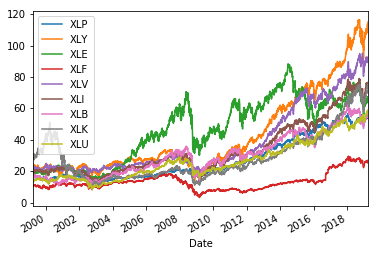

In [204]:
prices.plot()

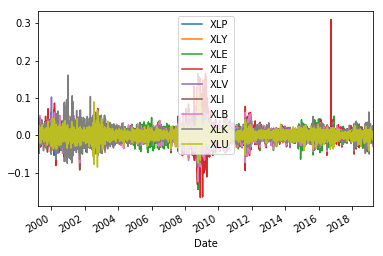

In [205]:
returns.plot()

In [206]:
#Create DF
#Add Y axis 
#rename ticker_returns
#max of next row
#last row remember to delete

from sklearn.preprocessing import LabelEncoder

df = returns.copy()
df.columns = [str(col) + '_returns' for col in df.columns]

#what if there are >1 max?
max_next_day = df.idxmax(axis = 1)
print(max_next_day.head())

df["max_next_day"] = max_next_day
df.max_next_day = df.max_next_day.shift(-1)

df.drop(df.tail(1).index,inplace=True) #remove last row

le = LabelEncoder()
df['labelencode_max_next_day'] = le.fit_transform(df['max_next_day'])
  
print(df.head())

Date
1999-04-01    XLU_returns
1999-04-05    XLK_returns
1999-04-06    XLK_returns
1999-04-07    XLF_returns
1999-04-08    XLU_returns
dtype: object
            XLP_returns  XLY_returns  XLE_returns  XLF_returns  XLV_returns  \
Date                                                                          
1999-04-01     0.001773    -0.001093    -0.001271     0.002506     0.000000   
1999-04-05     0.005310     0.013129     0.024173     0.020001     0.022321   
1999-04-06    -0.011151     0.005400    -0.009938    -0.007353     0.001090   
1999-04-07    -0.001186     0.008593    -0.010037     0.027161     0.019085   
1999-04-08     0.023173     0.022364     0.010139     0.018027     0.010167   

            XLI_returns  XLB_returns  XLK_returns  XLU_returns max_next_day  \
Date                                                                          
1999-04-01     0.010650     0.011495     0.015798     0.021077  XLK_returns   
1999-04-05     0.021700     0.012074     0.034469     0.0080

#Initial Analysis

In [207]:
#Check average daily returns
print(returns.mean(axis=0))

XLP    0.000283
XLY    0.000421
XLE    0.000421
XLF    0.000369
XLV    0.000355
XLI    0.000382
XLB    0.000394
XLK    0.000318
XLU    0.000363
dtype: float64


In [208]:
#Sector with Highest Returns
print("\n"+"Sector with Highest Returns: " + np.argmax(returns.mean(axis=0)))



Sector with Highest Returns: XLY


In [209]:
#Composition of Dataset
for ticker in returns.columns:
  print("% of Dataset max_next_day_return that is " + ticker + ": " + str(len(df[df["max_next_day"] == ticker+"_returns"])/len(df)))

% of Dataset max_next_day_return that is XLP: 0.08884913536076326
% of Dataset max_next_day_return that is XLY: 0.0725501888292586
% of Dataset max_next_day_return that is XLE: 0.20333929636255219
% of Dataset max_next_day_return that is XLF: 0.11329755515802027
% of Dataset max_next_day_return that is XLV: 0.08547008547008547
% of Dataset max_next_day_return that is XLI: 0.05108328364142318
% of Dataset max_next_day_return that is XLB: 0.10812959650168953
% of Dataset max_next_day_return that is XLK: 0.11965811965811966
% of Dataset max_next_day_return that is XLU: 0.15762273901808785


# Feature Engineering

## Day of Week

In [0]:
# dates = df.index.tolist()
# day_of_week=[]
# for i in range(0, len(dates)):
#   day = dates[i].to_pydatetime().weekday()
#   day_of_week.append(day)
# df['day_of_week'] = day_of_week

# df.head()

## ARIMA Time Series Model

In [211]:
#ARIMA
# !pip install pyramid-arima
from pyramid.arima import auto_arima

#Retrieve prices
arima_prices_dict = {}
for ticker in tickers:
    arima_ticker_prices = pdr.get_data_yahoo(ticker, arima_startdate, arima_enddate)
    arima_prices_dict[ticker] = arima_ticker_prices['Adj Close']

#Train data
arima_train_prices = pd.DataFrame(arima_prices_dict)
arima_train_data = arima_train_prices.sort_index(ascending=True, axis=0)

#Data for prediction
arima_output_prices = prices.copy()
arima_output_data = arima_output_prices.sort_index(ascending=True, axis=0)

arima_forecast = []

for ticker in tickers:
  train_arima = arima_train_data[ticker]
  valid_arima = arima_output_data[ticker]

  model = auto_arima(train_arima, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=False,error_action='ignore',suppress_warnings=True)
  model.fit(train_arima)

  forecast = model.predict(n_periods=5033)
  forecast = pd.DataFrame(forecast,index = valid_arima.index,columns=['Prediction'])
  arima_forecast.append(forecast)
arima_forecast_array = pd.Series(arima_forecast)

i = 0
for ticker in tickers:
  df[ticker + '_arima'] = arima_forecast_array[i]
  i += 1
del i

print(df.head())


            XLP_returns  XLY_returns  XLE_returns  XLF_returns  XLV_returns  \
Date                                                                          
1999-04-01     0.001773    -0.001093    -0.001271     0.002506     0.000000   
1999-04-05     0.005310     0.013129     0.024173     0.020001     0.022321   
1999-04-06    -0.011151     0.005400    -0.009938    -0.007353     0.001090   
1999-04-07    -0.001186     0.008593    -0.010037     0.027161     0.019085   
1999-04-08     0.023173     0.022364     0.010139     0.018027     0.010167   

            XLI_returns  XLB_returns  XLK_returns  XLU_returns max_next_day  \
Date                                                                          
1999-04-01     0.010650     0.011495     0.015798     0.021077  XLK_returns   
1999-04-05     0.021700     0.012074     0.034469     0.008025  XLK_returns   
1999-04-06    -0.005464    -0.017544     0.008533    -0.005118  XLF_returns   
1999-04-07     0.001832     0.010715    -0.002416  

## SMA

In [0]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
import talib

SMA_prices_dict = {}
for ticker in tickers:
    ticker_prices = pdr.get_data_yahoo(ticker, SMA_startdate, SMA_enddate)
    SMA_prices_dict[ticker] = ticker_prices['Adj Close']

#Returns
SMA_prices = pd.DataFrame(SMA_prices_dict)
length_SMA_data_added = len(SMA_prices_dict[tickers[0]])
SMA_prices = SMA_prices.append(prices)

#SMA Output
SMA_list = []
for ticker in tickers:
  output = talib.SMA(SMA_prices[ticker])
  SMA_list.append(output)

SMA_list = pd.Series(SMA_list)

#Remove the added data
#Take out added data length + 1 because Zijun deleted first date \
#when she labelled max_next_day and take out last data \
#because zijun also deleted last date
for i in range(0,len(tickers)):  
    SMA_list[i] = SMA_list[i][length_SMA_data_added+1:-1] 


#Store in df
i = 0
for ticker in tickers:
  df[ticker + '_SMA'] = SMA_list[i]
  i += 1
del i




## Bollinger Bands

In [0]:
BBbands_prices_dict = {}
for ticker in tickers:
    ticker_prices = pdr.get_data_yahoo(ticker, SMA_startdate, SMA_enddate)
    BBbands_prices_dict[ticker] = ticker_prices['Adj Close']

#Returns
BBbands_prices = pd.DataFrame(BBbands_prices_dict)
length_BBbands_data_added = len(BBbands_prices_dict[tickers[0]])
BBbands_prices = BBbands_prices.append(prices)

#BBbands Output
upper_BBbands_list = []
middle_BBbands_list = []
lower_BBbands_list = []
for ticker in tickers:
  upper, middle, lower = talib.BBANDS(BBbands_prices[ticker], matype=talib.MA_Type.T3)
  upper_BBbands_list.append(upper)
  middle_BBbands_list.append(middle)
  lower_BBbands_list.append(lower)

upper_BBbands_list = pd.Series(upper_BBbands_list)
middle_BBbands_list = pd.Series(middle_BBbands_list)
lower_BBbands_list = pd.Series(lower_BBbands_list)

#Remove the added data
#Take out added data length + 1 because Zijun deleted first date \
#when she labelled max_next_day and take out last data \
#because zijun also deleted last date
for i in range(0,len(tickers)):  
    upper_BBbands_list[i] = upper_BBbands_list[i][length_BBbands_data_added+1:-1] 
    middle_BBbands_list[i] = middle_BBbands_list[i][length_BBbands_data_added+1:-1] 
    lower_BBbands_list[i] = lower_BBbands_list[i][length_BBbands_data_added+1:-1] 


#Store in df
i = 0
for ticker in tickers:
  df[ticker + '_upper_BBbands'] = upper_BBbands_list[i]
  df[ticker + '_middle_BBbands'] = middle_BBbands_list[i]
  df[ticker + '_lower_BBbands'] = lower_BBbands_list[i]
  i += 1
del i

## Data Pre-processing

In [0]:
#create x and y
x = df.drop(['max_next_day', 'labelencode_max_next_day'], axis=1).copy() #making copies so editing x & y wouldnt change df
y = df['labelencode_max_next_day'].copy()

#Change to between 0 to 1
scaler = MinMaxScaler()
  
x_values = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_values)
x = pd.DataFrame(x_scaled, columns=x.columns)


In [215]:
x.head()

,XLP_returns,XLY_returns,XLE_returns,XLF_returns,XLV_returns,XLI_returns,XLB_returns,XLK_returns,XLU_returns,XLP_arima,...,XLI_lower_BBbands,XLB_upper_BBbands,XLB_middle_BBbands,XLB_lower_BBbands,XLK_upper_BBbands,XLK_middle_BBbands,XLK_lower_BBbands,XLU_upper_BBbands,XLU_middle_BBbands,XLU_lower_BBbands
0,0.480364,0.538107,0.463047,0.355149,0.447977,0.520634,0.512341,0.413390,0.516285,0.000023,...,0.083301,0.052027,0.053325,0.057538,0.301097,0.299773,0.297584,0.088060,0.088364,0.093784
1,0.507757,0.604564,0.545340,0.391875,0.550191,0.575580,0.514528,0.488812,0.452929,0.000000,...,0.082622,0.052736,0.053709,0.057573,0.307984,0.304480,0.299967,0.088471,0.088110,0.092858
2,0.380255,0.568446,0.435014,0.334451,0.452971,0.440502,0.402636,0.384040,0.389129,0.000053,...,0.083526,0.053068,0.053903,0.057618,0.319048,0.310263,0.300245,0.089128,0.088461,0.092895
3,0.457439,0.583368,0.434694,0.406907,0.535373,0.476784,0.509396,0.339813,0.477813,0.000044,...,0.084712,0.053435,0.054161,0.057757,0.325430,0.315870,0.304943,0.090439,0.089467,0.093583
4,0.646129,0.647719,0.499950,0.387732,0.494534,0.494926,0.522313,0.388729,0.542705,0.000118,...,0.088209,0.054513,0.054937,0.058197,0.325119,0.321046,0.315601,0.094309,0.091629,0.093992


## Final Check for Null Values

In [217]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

XLP_returns                 0
XLY_returns                 0
XLE_returns                 0
XLF_returns                 0
XLV_returns                 0
XLI_returns                 0
XLB_returns                 0
XLK_returns                 0
XLU_returns                 0
max_next_day                0
labelencode_max_next_day    0
XLP_arima                   0
XLY_arima                   0
XLE_arima                   0
XLF_arima                   0
XLV_arima                   0
XLI_arima                   0
XLB_arima                   0
XLK_arima                   0
XLU_arima                   0
XLP_SMA                     0
XLY_SMA                     0
XLE_SMA                     0
XLF_SMA                     0
XLV_SMA                     0
XLI_SMA                     0
XLB_SMA                     0
XLK_SMA                     0
XLU_SMA                     0
XLP_upper_BBbands           0
XLP_middle_BBbands          0
XLP_lower_BBbands           0
XLY_upper_BBbands           0
XLY_middle

## Split Testing and Training Set 

In [0]:
#Split Test and Train set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Training models

In [0]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [220]:
#SVM
clf1 = svm.SVC(gamma='scale')
clf1.fit(x_train, y_train)
clf1_predictions = clf1.predict(x_test)
print(clf1.score(x_test, y_test))

0.23359422034918723


In [221]:
#Random Forest
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2.fit(x_train, y_train)
clf2_predictions = clf2.predict(x_test)
print(clf2.score(x_test, y_test))

0.1715833835039133


In [222]:
#Regression
clf3 = LinearRegression()
clf3.fit(x_train, y_train)
clf3_predictions = clf3.predict(x_test)
clf3_predictions = np.rint(clf3_predictions)
clf3_predictions = clf3_predictions.astype(int)
print(clf3.score(x_test, y_test))

0.009140405206318647


In [223]:
clf3_predictions

array([4, 3, 4, ..., 4, 3, 3])

In [224]:
clf1_predictions_reshaped = clf1_predictions.reshape(-1,1)
df_predictions = pd.DataFrame(clf1_predictions_reshaped, columns=['clf1'])

clf2_predictions_reshaped = clf2_predictions.reshape(-1,1)
df_predictions['clf2'] = clf2_predictions_reshaped

clf3_predictions_reshaped = clf3_predictions.reshape(-1,1)
df_predictions['clf3'] = clf3_predictions_reshaped

df_predictions.head()

,clf1,clf2,clf3
0,6,6,4
1,1,6,3
2,6,4,4
3,6,1,3
4,2,6,4


#Stacking Training

In [0]:
from sklearn.neural_network import MLPClassifier

In [226]:
#Neural Networking Stacking Model
clf4 = MLPClassifier(hidden_layer_sizes=100, solver='sgd', learning_rate='adaptive') #adaptive only for sgd
clf4.fit(df_predictions, y_test)

print(clf4.score(df_predictions, y_test))

0.22456351595424442


#Testing of Models

In [227]:
#Test Score
print('Test score for clf1: ' + str(clf1.score(x_test, y_test)))
print('Test score for clf2: ' + str(clf2.score(x_test, y_test)))
print('Test score for clf3: ' + str(clf3.score(x_test, y_test)))
print('Test score for clf4: ' + str(clf4.score(df_predictions, y_test)))


Test score for clf1: 0.23359422034918723
Test score for clf2: 0.1715833835039133
Test score for clf3: 0.009140405206318647
Test score for clf4: 0.22456351595424442


# Post-Analysis

In [228]:
#Find best feature for Random Forest 
importances = clf2.feature_importances_
indices = range(0, len(importances))

for i in range(0,len(importances)):
  print(str(x.columns[i]) +' importances: ' + str(importances[i]))

XLP_returns importances: 0.02951654109619871
XLY_returns importances: 0.027575314292705815
XLE_returns importances: 0.03185033340003823
XLF_returns importances: 0.02887884166131198
XLV_returns importances: 0.03010945795123174
XLI_returns importances: 0.026867332571627666
XLB_returns importances: 0.02797586491849229
XLK_returns importances: 0.02856222107567397
XLU_returns importances: 0.02962848098755018
XLP_arima importances: 0.011002034505062095
XLY_arima importances: 0.011482158240434208
XLE_arima importances: 0.010870076132332058
XLF_arima importances: 0.011426866682517243
XLV_arima importances: 0.011220930779703129
XLI_arima importances: 0.011461163349830338
XLB_arima importances: 0.010038114076441782
XLK_arima importances: 0.011650937350583661
XLU_arima importances: 0.011062849035460821
XLP_SMA importances: 0.015197465775655563
XLY_SMA importances: 0.016689543321965816
XLE_SMA importances: 0.018641461641786948
XLF_SMA importances: 0.018017744168566937
XLV_SMA importances: 0.016743

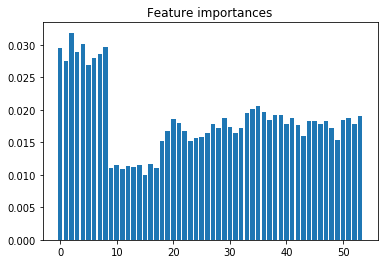

In [229]:
# Plot the feature importances of the forest
features = x.columns
plt.figure()
plt.title("Feature importances")
plt.bar (indices, importances)
plt.show()

In [230]:
#Max importance
max_importance = 0

for i in range(0,len(importances)):
  if importances[i] >= importances[max_importance]:
    max_importance = i
print('Most important feature is: ' + str(x.columns[max_importance]))

Most important feature is: XLE_returns


# Export Model

In [0]:
#Save Model

#Export Model
#Run for google, otherwise comment this and run below

# from google.colab import drive
# drive.mount('/content/gdrive')
# result.to_csv("/content/gdrive/My Drive/Colab Notebooks/submission_file.csv", index=False)

# #Run for local machine
# result.to_csv("./submission_file.csv", index=False)